In [3]:

%pip install pandas numpy scikit-learn matplotlib seaborn openpyxl


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Internship Projects\ProductRecommendation4\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder


In [3]:
# Adjust path if needed
DATA_PATH = "recommendation_dataset_60k_with_names.xlsx"

# Read into DataFrame
df = pd.read_excel(DATA_PATH)

# Quick peek
print(df.shape)
df.head()


(60000, 19)


,txn_id,customer_id,txn_timestamp,product_id,product_name,qty,list_price,channel,customer_rating,rec_type,recommended_product_id,recommended_product_name,bundle_id,bundle_name,bundle_products,target_segment,score,explanation,generated_ts
0,TXN0000001,CUST10803,2024-07-27 05:19:15,PROD070,Premium Sunglasses,5,290.50,Partner,3,XSELL,PROD069,Rechargeable Sneakers,NaN,NaN,NaN,NaN,0.80,Based on xsell propensity and affinity score,2024-07-27 06:00:15
1,TXN0000002,CUST28006,2025-01-01 02:08:03,PROD027,Smart Desk Lamp,5,187.28,Mobile,3,XSELL,PROD033,Portable LED TV,NaN,NaN,NaN,NaN,0.40,Based on xsell propensity and affinity score,2025-01-01 02:35:03
2,TXN0000003,CUST13443,2024-02-24 17:29:19,PROD053,Portable LED TV,4,305.50,Partner,3,XSELL,PROD051,Organic Headphones,NaN,NaN,NaN,NaN,0.25,Based on xsell propensity and affinity score,2024-02-24 18:12:19
3,TXN0000004,CUST55955,2024-06-17 06:41:51,PROD038,Eco-friendly Backpack,4,447.76,In-Store,5,XSELL,PROD079,Rechargeable Sneakers,NaN,NaN,NaN,NaN,0.91,Based on xsell propensity and affinity score,2024-06-17 07:15:51
4,TXN0000005,CUST30511,2024-07-11 16:08:51,PROD013,Portable LED TV,3,224.90,Mobile,5,XSELL,PROD034,Deluxe Bluetooth Speaker,NaN,NaN,NaN,NaN,0.97,Based on xsell propensity and affinity score,2024-07-11 17:07:51


In [4]:
# Convert timestamps
df['txn_timestamp'] = pd.to_datetime(df['txn_timestamp'], errors='coerce')

# Fill or drop missing
df.fillna({
    'recommended_product_id': 'NA',
    'recommended_product_name': 'NA',
    'bundle_id': 'NA',
    'bundle_products': ''
}, inplace=True)

# Ensure numeric types
df['qty'] = pd.to_numeric(df['qty'], errors='coerce').fillna(0).astype(int)
df['list_price'] = pd.to_numeric(df['list_price'], errors='coerce')

# Verify
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   txn_id                    60000 non-null  object        
 1   customer_id               60000 non-null  object        
 2   txn_timestamp             60000 non-null  datetime64[ns]
 3   product_id                60000 non-null  object        
 4   product_name              60000 non-null  object        
 5   qty                       60000 non-null  int64         
 6   list_price                60000 non-null  float64       
 7   channel                   60000 non-null  object        
 8   customer_rating           60000 non-null  int64         
 9   rec_type                  60000 non-null  object        
 10  recommended_product_id    60000 non-null  object        
 11  recommended_product_name  60000 non-null  object        
 12  bundle_id         

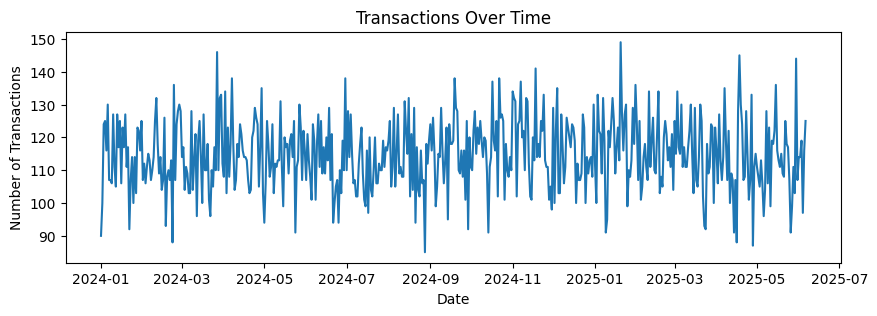

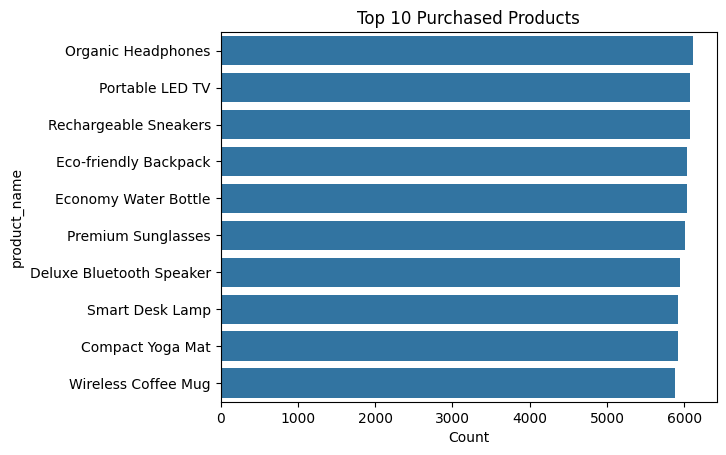

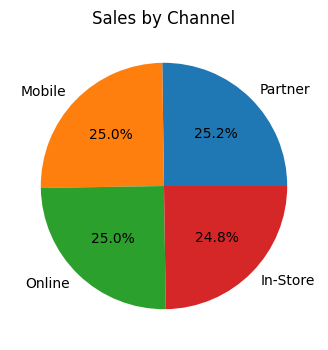

In [5]:
# Distribution of transaction dates
df['txn_timestamp'].dt.date.value_counts().sort_index().plot(
    figsize=(10,3), title="Transactions Over Time"
)
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.show()

# Top 10 products
top10 = df['product_name'].value_counts().head(10)
sns.barplot(x=top10.values, y=top10.index)
plt.title("Top 10 Purchased Products")
plt.xlabel("Count")
plt.show()

# Channel breakdown
df['channel'].value_counts().plot.pie(
    autopct='%1.1f%%', figsize=(4,4), title="Sales by Channel"
)
plt.ylabel("")
plt.show()


In [6]:
# If we need label encoding later
le_channel = LabelEncoder()
df['channel_enc'] = le_channel.fit_transform(df['channel'])


In [7]:
cust_prod = df.pivot_table(
    index='customer_id',
    columns='product_id',
    values='qty',
    aggfunc='sum'
).fillna(0)

cust_prod.shape  # (#customers, #products)


(38046, 100)

In [8]:
# Product–Product similarity
prod_sim = cosine_similarity(cust_prod.T)
prod_sim_df = pd.DataFrame(prod_sim,
                           index=cust_prod.columns,
                           columns=cust_prod.columns)

# Customer–Customer similarity
user_sim = cosine_similarity(cust_prod)
user_sim_df = pd.DataFrame(user_sim,
                           index=cust_prod.index,
                           columns=cust_prod.index)


In [9]:
# 1) Item‑based (product affinity)
def recommend_items(customer_id, top_n=5):
    if customer_id not in cust_prod.index:
        return []
    purchased = cust_prod.loc[customer_id]
    bought = purchased[purchased>0].index.tolist()
    scores = {}
    for pid in bought:
        sims = prod_sim_df[pid].sort_values(ascending=False)[1:top_n+1]
        for rec, sc in sims.items():
            if rec not in bought:
                scores[rec] = max(scores.get(rec,0), sc)
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

# 2) User‑based (collaborative)
def recommend_users(customer_id, top_n=5):
    if customer_id not in user_sim_df.index:
        return []
    sims = user_sim_df[customer_id].sort_values(ascending=False)[1:6]
    neighbors = sims.index
    agg = cust_prod.loc[neighbors].sum()
    bought = cust_prod.loc[customer_id]
    recs = agg[bought==0].sort_values(ascending=False).head(top_n)
    return list(zip(recs.index, recs.values))

# Test
print("Item-based for CUST10803:", recommend_items("CUST10803"))
print("User-based for CUST10803:", recommend_users("CUST10803"))


Item-based for CUST10803: [('PROD023', 0.023573233529937287), ('PROD089', 0.01972507758199611), ('PROD087', 0.018516750409266026), ('PROD033', 0.018367257858791803), ('PROD061', 0.017625603297766853)]
User-based for CUST10803: [('PROD006', np.float64(2.0)), ('PROD087', np.float64(1.0)), ('PROD003', np.float64(0.0)), ('PROD004', np.float64(0.0)), ('PROD005', np.float64(0.0))]


In [10]:
# Map product_id to product_name
prod_map = df[['product_id','product_name']].drop_duplicates().set_index('product_id')['product_name'].to_dict()

def show_recs(customer_id):
    items = recommend_items(customer_id)
    users = recommend_users(customer_id)
    return {
        "ItemType": [(prod_map[p], round(s,3)) for p,s in items],
        "UserType": [(prod_map[p], int(score)) for p,score in users]
    }

show_recs("CUST10803")


{'ItemType': [('Portable LED TV', 0.024),
  ('Rechargeable Sneakers', 0.02),
  ('Smart Desk Lamp', 0.019),
  ('Portable LED TV', 0.018),
  ('Organic Headphones', 0.018)],
 'UserType': [('Compact Yoga Mat', 2),
  ('Smart Desk Lamp', 1),
  ('Portable LED TV', 0),
  ('Deluxe Bluetooth Speaker', 0),
  ('Economy Water Bottle', 0)]}

In [11]:
# We’ll reuse these
cust_prod.to_pickle("cust_prod_matrix.pkl")
prod_sim_df.to_pickle("product_similarity.pkl")
user_sim_df.to_pickle("user_similarity.pkl")


In [12]:
# Phase 2 will reuse the pickled matrices from Phase 1
cust_prod = pd.read_pickle("cust_prod_matrix.pkl")
prod_sim_df = pd.read_pickle("product_similarity.pkl")
user_sim_df = pd.read_pickle("user_similarity.pkl")


In [13]:
# For each customer-product pair, compute a recency weight in [0,1]:
#   weight = exp(-λ * days_since_last_purchase)
import numpy as np

# 1) Get last-purchase date per customer-product
last_dates = (
    df.groupby(['customer_id','product_id'])['txn_timestamp']
      .max()
      .reset_index()
      .rename(columns={'txn_timestamp':'last_purchase'})
)

# 2) Merge with today's date
today = df['txn_timestamp'].max()  # or pd.Timestamp.today()
last_dates['days_since'] = (today - last_dates['last_purchase']).dt.days

# 3) Exponential decay: λ=0.01 (tuneable)
λ = 0.01
last_dates['recency_weight'] = np.exp(-λ * last_dates['days_since'])

# 4) Pivot to matrix
recency_mat = last_dates.pivot_table(
    index='customer_id', columns='product_id', values='recency_weight', fill_value=0
)


In [17]:
# 1) Compute each customer's average spend per transaction
cust_spend = (
    df
    .assign(total_price = df['qty'] * df['list_price'])
    .groupby('customer_id')['total_price']
    .mean()
    .rename('avg_spend')
)

# 2) Compute each product's average price
prod_price = (
    df
    .groupby('product_id')['list_price']
    .mean()
    .rename('mean_price')
)

# 3) Prepare for cross-join by resetting indices
cust_price = cust_spend.reset_index().assign(key=1)
prod_price_df = prod_price.reset_index().assign(key=1)

# 4) Merge and drop the helper key
cp = cust_price.merge(prod_price_df, on='key').drop(columns='key')

# Now cp has columns: customer_id, avg_spend, product_id, mean_price

# 5) Compute price sensitivity weight
#    weight = 1 / (1 + |mean_price - avg_spend| / avg_spend)
cp['price_weight'] = 1 / (1 + (cp['mean_price'] - cp['avg_spend']).abs() / cp['avg_spend'])

# 6) Pivot back into matrix form
price_mat = cp.pivot_table(
    index='customer_id',
    columns='product_id',
    values='price_weight',
    fill_value=0
)

price_mat.head()


product_id,PROD001,PROD002,PROD003,PROD004,PROD005,PROD006,PROD007,PROD008,PROD009,PROD010,...,PROD091,PROD092,PROD093,PROD094,PROD095,PROD096,PROD097,PROD098,PROD099,PROD100
customer_id,,,,,,,,,,,,,,,,,,,,,
CUST00001,0.631097,0.548744,0.538590,0.599280,0.636451,0.573734,0.704331,0.628424,0.584983,0.567884,...,0.633063,0.708557,0.561197,0.646728,0.608125,0.629997,0.526152,0.569149,0.540954,0.558931
CUST00003,0.600000,0.538370,0.530496,0.576647,0.603875,0.557483,0.651687,0.598059,0.565968,0.553042,...,0.601425,0.654585,0.547940,0.611269,0.583195,0.599202,0.520768,0.554004,0.532335,0.546205
CUST00004,0.570323,0.527831,0.522210,0.554530,0.572909,0.541292,0.604012,0.569025,0.547185,0.538188,...,0.571275,0.605852,0.534604,0.577815,0.558996,0.569790,0.515200,0.538862,0.523526,0.533381
CUST00005,0.819342,0.600000,0.577657,0.725512,0.836483,0.658874,0.918585,0.810938,0.687355,0.644567,...,0.825587,0.905370,0.628616,0.870598,0.750300,0.815871,0.551425,0.647634,0.582782,0.623304
CUST00007,0.809918,0.679338,0.635272,0.984906,0.784741,0.808974,0.579938,0.823277,0.879879,0.775500,...,0.800439,0.571595,0.739730,0.741561,0.946252,0.815350,0.586658,0.782561,0.645154,0.728162


In [18]:
def hybrid_recommendations(customer_id, top_n=5,
                           w_item=0.4, w_user=0.3, w_recency=0.2, w_price=0.1):
    """
    Compute a weighted hybrid score for each product the customer has not bought,
    combining:
      • Item-based similarity
      • User-based similarity
      • Recency weight
      • Price sensitivity weight
    Returns top_n (product_id, score) pairs.
    """
    # 1) Ensure customer exists
    if customer_id not in cust_prod.index:
        return []

    # 2) Identify products already purchased
    customer_vector = cust_prod.loc[customer_id]
    purchased_ids = customer_vector[customer_vector > 0].index.tolist()

    scores = {}
    # 3) Iterate over every product as candidate
    for prod in cust_prod.columns:
        if prod in purchased_ids:
            continue

        # a) Item-based score: max similarity to any purchased item
        item_score = 0
        for bought in purchased_ids:
            item_score = max(item_score, prod_sim_df.at[prod, bought])

        # b) User-based score: average similarity to users who bought this product
        buyers = cust_prod[cust_prod[prod] > 0].index
        user_score = user_sim_df.loc[customer_id, buyers].mean() if len(buyers) else 0

        # c) Recency weight (0–1)
        recency_score = recency_mat.at[customer_id, prod] if prod in recency_mat.columns else 0

        # d) Price sensitivity weight (0–1)
        price_score = price_mat.at[customer_id, prod] if prod in price_mat.columns else 0

        # 4) Combine with weights
        hybrid_score = (
            w_item * item_score +
            w_user * user_score +
            w_recency * recency_score +
            w_price * price_score
        )
        scores[prod] = hybrid_score

    # 5) Return top_n sorted products
    top = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top


In [19]:
# Pick a sample customer
sample_cust = df['customer_id'].iloc[0]

# Get top 5 hybrid recommendations
hyb_recs = hybrid_recommendations(sample_cust, top_n=5)

# Map to product names and round scores
[(prod_map[p], round(score, 3)) for p, score in hyb_recs]


[('Portable LED TV', np.float64(0.076)),
 ('Rechargeable Sneakers', np.float64(0.074)),
 ('Wireless Coffee Mug', np.float64(0.074)),
 ('Eco-friendly Backpack', np.float64(0.074)),
 ('Eco-friendly Backpack', np.float64(0.073))]

In [2]:
def generate_hybrid_recommendations(customer_id, top_n=5):
    # 1) Latest purchase history (up to 5 items)
    recent = (
        df[df['customer_id'] == customer_id]
          .sort_values('txn_timestamp', ascending=False)
          .head(5)['product_id']
          .tolist()
    )
    recent_names = [prod_map[pid] for pid in recent]

    # 2) Hybrid recommendation
    recs = hybrid_recommendations(customer_id, top_n=top_n)
    rec_ids = [pid for pid, _ in recs]
    rec_names = [prod_map[pid] for pid in rec_ids]

    # 3) Generate explanation via OpenRouter LLaMA 3.2
    explanation = get_llama3_explanation(recent_names, rec_names)

    # 4) Return all pieces
    return {
        "purchase_history": recent_names,
        "recommendations": [(name, round(score,3)) for name, score in zip(rec_names, [s for _,s in recs])],
        "explanation": explanation
    }


In [21]:
# Prompt templates for each mode
PROMPT_TEMPLATES = {
    "Item Type": """
You are a helpful shopping assistant. 
The customer recently purchased: {purchased}.
We are recommending: {recommended}.
First, explain how these items are similar to their past purchase(s). 
Then, briefly mention why that benefits the customer.
Keep it to 2–3 sentences.
""".strip(),

    "Customer Type": """
You are a savvy shopping advisor. 
List the customer’s past purchases: {purchased}.
Recommend the following based on what other similar customers bought: {recommended}.
Explain in two sentences:
1. Why peers’ purchases matter.
2. What value these recommendations bring.
""".strip(),

    "Hybrid": """
You are an AI shopping concierge. 
The customer has history: {purchased}.
You’re using a hybrid score combining product affinity, peer influence, recency, and price match.
Recommended products: {recommended}.
Provide a cohesive 3‑sentence explanation:
• How each factor contributed.
• Why these products fit the customer’s needs.
• A call‑to‑action tone.
""".strip()
}


In [ ]:
import requests
import json
def get_rich_explanation(purchased, recommended, mode="Hybrid"):
    """
    Constructs a detailed prompt using the appropriate template,
    then calls OpenRouter LLaMA 3.2 API to generate a multi-sentence explanation.
    """
    # 1) Format the purchased/recommended lists
    purchased_str = ", ".join(purchased)
    recommended_str = ", ".join(recommended)

    # 2) Select template
    template = PROMPT_TEMPLATES.get(mode, PROMPT_TEMPLATES["Hybrid"])
    prompt = template.format(purchased=purchased_str, recommended=recommended_str)

    # 3) Call the API
    payload = {
        "model": "meta-llama/llama-3.2-3b-instruct:free",
        "messages": [
      {
        "role": "user",
        "content": "What is the meaning of life?"
      }
    ]
    }
    headers = {
        "Authorization": "Bearer <OPENROUTER_API_KEY>",
        "Content-Type": "application/json"
    }
    response = requests.post(
        "https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        data=json.dumps(payload),
        timeout=20
    )

    if not response.ok:
        return f"[Error {response.status_code}] {response.text}"
    content = response.json()["choices"][0]["message"]["content"].strip()
    return content


In [33]:
# Update generate_recommendations (item/customer) to use rich explanations
def generate_recommendations(customer_id, method='Item Type', top_n=5):
    recent = (
        df[df['customer_id']==customer_id]
          .sort_values('txn_timestamp', ascending=False)
          .head(5)['product_id']
          .tolist()
    )
    purchased_names = [prod_map[p] for p in recent]

    if method == "Item Type":
        recs = recommend_items(customer_id, top_n)
    else:
        recs = recommend_users(customer_id, top_n)

    rec_ids = [pid for pid,_ in recs]
    rec_names = [prod_map[pid] for pid in rec_ids]

    explanation = get_rich_explanation(purchased_names, rec_names, mode=method)
    return purchased_names, list(zip(rec_names, [round(s,3) for _,s in recs])), explanation

# Update hybrid generator likewise
def generate_hybrid_recommendations(customer_id, top_n=5):
    recent = (
        df[df['customer_id']==customer_id]
          .sort_values('txn_timestamp', ascending=False)
          .head(5)['product_id']
          .tolist()
    )
    purchased_names = [prod_map[p] for p in recent]

    recs = hybrid_recommendations(customer_id, top_n)
    rec_ids = [pid for pid,_ in recs]
    rec_names = [prod_map[pid] for pid in rec_ids]

    explanation = get_rich_explanation(purchased_names, rec_names, mode="Hybrid")
    return {
        "purchase_history": purchased_names,
        "recommendations": [(name, round(score,3)) for name,score in recs],
        "explanation": explanation
    }


In [34]:
cust = df['customer_id'].iloc[0]

for mode in ["Item Type", "Customer Type", "Hybrid"]:
    if mode == "Hybrid":
        data = generate_hybrid_recommendations(cust, top_n=3)
        print(f"\n=== {mode} ===")
        print("History:", data["purchase_history"])
        print("Recs   :", data["recommendations"])
        print("Explain:")
        print(data["explanation"])
    else:
        purchased, recs, expl = generate_recommendations(cust, method=mode, top_n=3)
        print(f"\n=== {mode} ===")
        print("History:", purchased)
        print("Recs   :", recs)
        print("Explain:")
        print(expl)



=== Item Type ===
History: ['Premium Sunglasses', 'Wireless Coffee Mug']
Recs   : [('Portable LED TV', 0.024), ('Rechargeable Sneakers', 0.02), ('Smart Desk Lamp', 0.019)]
Explain:
The items we're recommending, such as the Portable LED TV, Rechargeable Sneakers, and Smart Desk Lamp, are similar to the Wireless Coffee Mug and Premium Sunglasses in that they offer convenience, portability, and innovative functionality. These features are likely to appeal to the customer's desire for ease and flexibility, as seen in their previous purchase of the Wirelesss Coffee Mug, which also prioritizes convenience. This means they'll likely appreciate a similar seamless experience with the new recommendations.

=== Customer Type ===
History: ['Premium Sunglasses', 'Wireless Coffee Mug']
Recs   : [('Compact Yoga Mat', np.float64(2.0)), ('Smart Desk Lamp', np.float64(1.0)), ('Portable LED TV', np.float64(0.0))]
Explain:
Based on the customer's past purchases, here are my recommendations:

**Recommenda